In [1]:
import scipy.io
import numpy as np
import os
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def _conv_layer(_input,weights,bias):
    #tf.constant(weights)表示转换为Tensorflow支持的格式
    conv=tf.nn.conv2d(_input,tf.constant(weights),strides=(1,1,1,1),padding='SAME')
    return tf.nn.bias_add(conv,bias)
def _pool_layer(_input):
    return tf.nn.max_pool(_input,ksize=(1,2,2,1),strides=(1,2,2,1),padding='SAME')
def preprocess(image,mean_pixel):
    return image-mean_pixel
def unprocess(image,mean_pixel):
    return image+mean_pixel
def imread(path):
    return scipy.misc.imread(path).astype(np.float)
def imsave(path,img):
    img=np.clip(img,0,255).astype(np.uint8)
    scipy.misc.imsave(path,img)
print("Functions for VGG ready")

Functions for VGG ready


In [3]:
def net(data_path,input_image):#做加载参数的操作
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',
        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )
    data=scipy.io.loadmat(data_path)
    mean=data['normalization'][0][0][0]
    #所有的输入在RGB三个通道上做减均值的操作，这里我们需要知道他们减的均值是多少。
    mean_pixel=np.mean(mean,axis=(0,1))
    print(mean_pixel)  
    #这就是三个通道的均值，所以在测试的时候我们也需要把我们的输入做减均值的操作
    weights=data['layers'][0]
    net={}#不断的去保存前向传播的结果，保存每一层输出的结果的值
    current=input_image
    for i,name in enumerate(layers):
        kind=name[:4]
        if(kind=='conv'):
            kernels,bias=weights[i][0][0][0][0]
            kernels=np.transpose(kernels,(1,0,2,3)) 
            #0表示宽，1表示长，所以我们要转换格式
            bias=bias.reshape(-1)   #(1*64)维度的改成1个维度就可以了
            current=_conv_layer(current,kernels,bias)
            #current是当前输入,kernels是参数W,bias是参数b
        elif(kind=='relu'):
            current=tf.nn.relu(current)
        elif(kind=='pool'):
            current=_pool_layer(current)
        net[name]=current   #name表示每个层的名字，value表示每个层的前向传播结果
    assert len(net)==len(layers)
    return net,mean_pixel,layers
    

[ 123.68   116.779  103.939]
[1/36] conv1_1
 Type of 'features' is  <class 'numpy.ndarray'>
 Shape of 'features' is (1, 1797, 2673, 64)


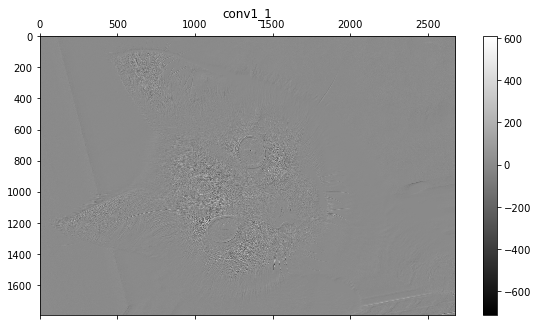

[2/36] relu1_1


KeyboardInterrupt: 

In [4]:
VGG_PATH='F://VGG/imagenet-vgg-verydeep-19.mat'
IMG_PATH='F://VGG/cat.jpg'
input_image=imread(IMG_PATH)
shape=(1,input_image.shape[0],input_image.shape[1],input_image.shape[2])
with tf.Session() as sess:
    image=tf.placeholder(tf.float32,shape=shape)
    nets,mean_pixel,all_layers=net(VGG_PATH,image)
    input_image=np.array([preprocess(input_image,mean_pixel)])#减均值操作
    layers=all_layers
    for i,layer in enumerate(layers):
        print("[%d/%d] %s" % (i+1,len(layers),layer))
        features=nets[layer].eval(feed_dict={image:input_image})
        print (" Type of 'features' is ", type(features))
        print (" Shape of 'features' is %s" % (features.shape,))
        # Plot response 
        if 1:
            plt.figure(i+1, figsize=(10, 5))
            plt.matshow(features[0, :, :, 0], cmap=plt.cm.gray, fignum=i+1)
            plt.title("" + layer)
            plt.colorbar()
            plt.show()
        

In [37]:
#cwd=os.getcwd()#找到当前的路径
VGG_PATH='F://VGG/imagenet-vgg-verydeep-19.mat'
IMG_PATH='F://VGG/cat.jpg'
input_image=imread(IMG_PATH)
data=scipy.io.loadmat(VGG_PATH)
mean=data['normalization'][0][0][0] 
#所有的输入在RGB三个通道上做减均值的操作，这里我们需要知道他们减的均值是多少。
mean_pixel=np.mean(mean,axis=(0,1))
print(mean_pixel)  
#这就是三个通道的均值，所以在测试的时候我们也需要把我们的输入做减均值的操作
weights=data['layers'][0]
#print(weights)
print(weights[0][0][0][0][0][0].shape) 
#第一个参数是0的话是指定的卷积层，1的话是relu
#最后一个参数0代表W,1代表b
print(weights[0][0][0][0][0][1].shape)

[ 123.68   116.779  103.939]
(3, 3, 3, 64)
(1, 64)
